Step 1: Import Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)

Step 2: Load and Clean the Data

In [24]:
obesity = pd.read_csv("obesity.csv")

obesity.drop(columns=['Weight'], inplace=True)

print(obesity.shape)
print(obesity.dtypes)
print(obesity.head())

print(obesity.describe())

print(obesity.describe(include=['object']))

(2111, 16)
Gender                             object
Age                               float64
Height                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
   Gender   Age  Height family_history_with_overweight FAVC  FCVC  NCP  \
0  Female  21.0    1.62                            yes   no   2.0  3.0   
1  Female  21.0    1.52                            yes   no   3.0  3.0   
2    Male  23.0    1.80                            yes   no   2.0  3.0   
3    Ma

Step 3: Plot Histograms and Bar Charts

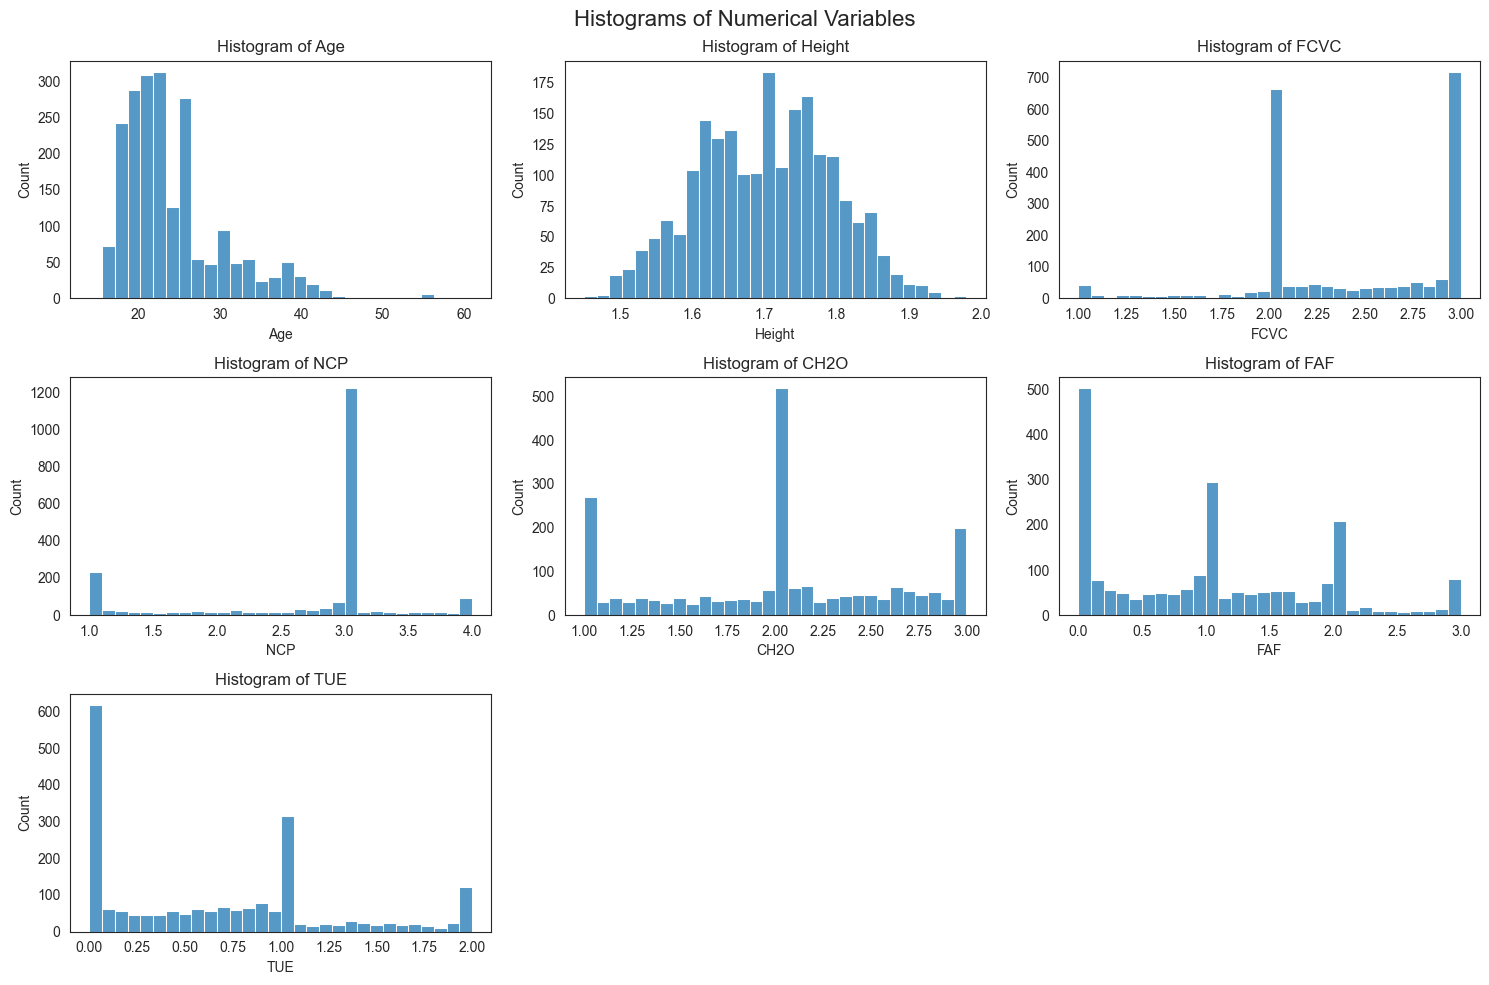

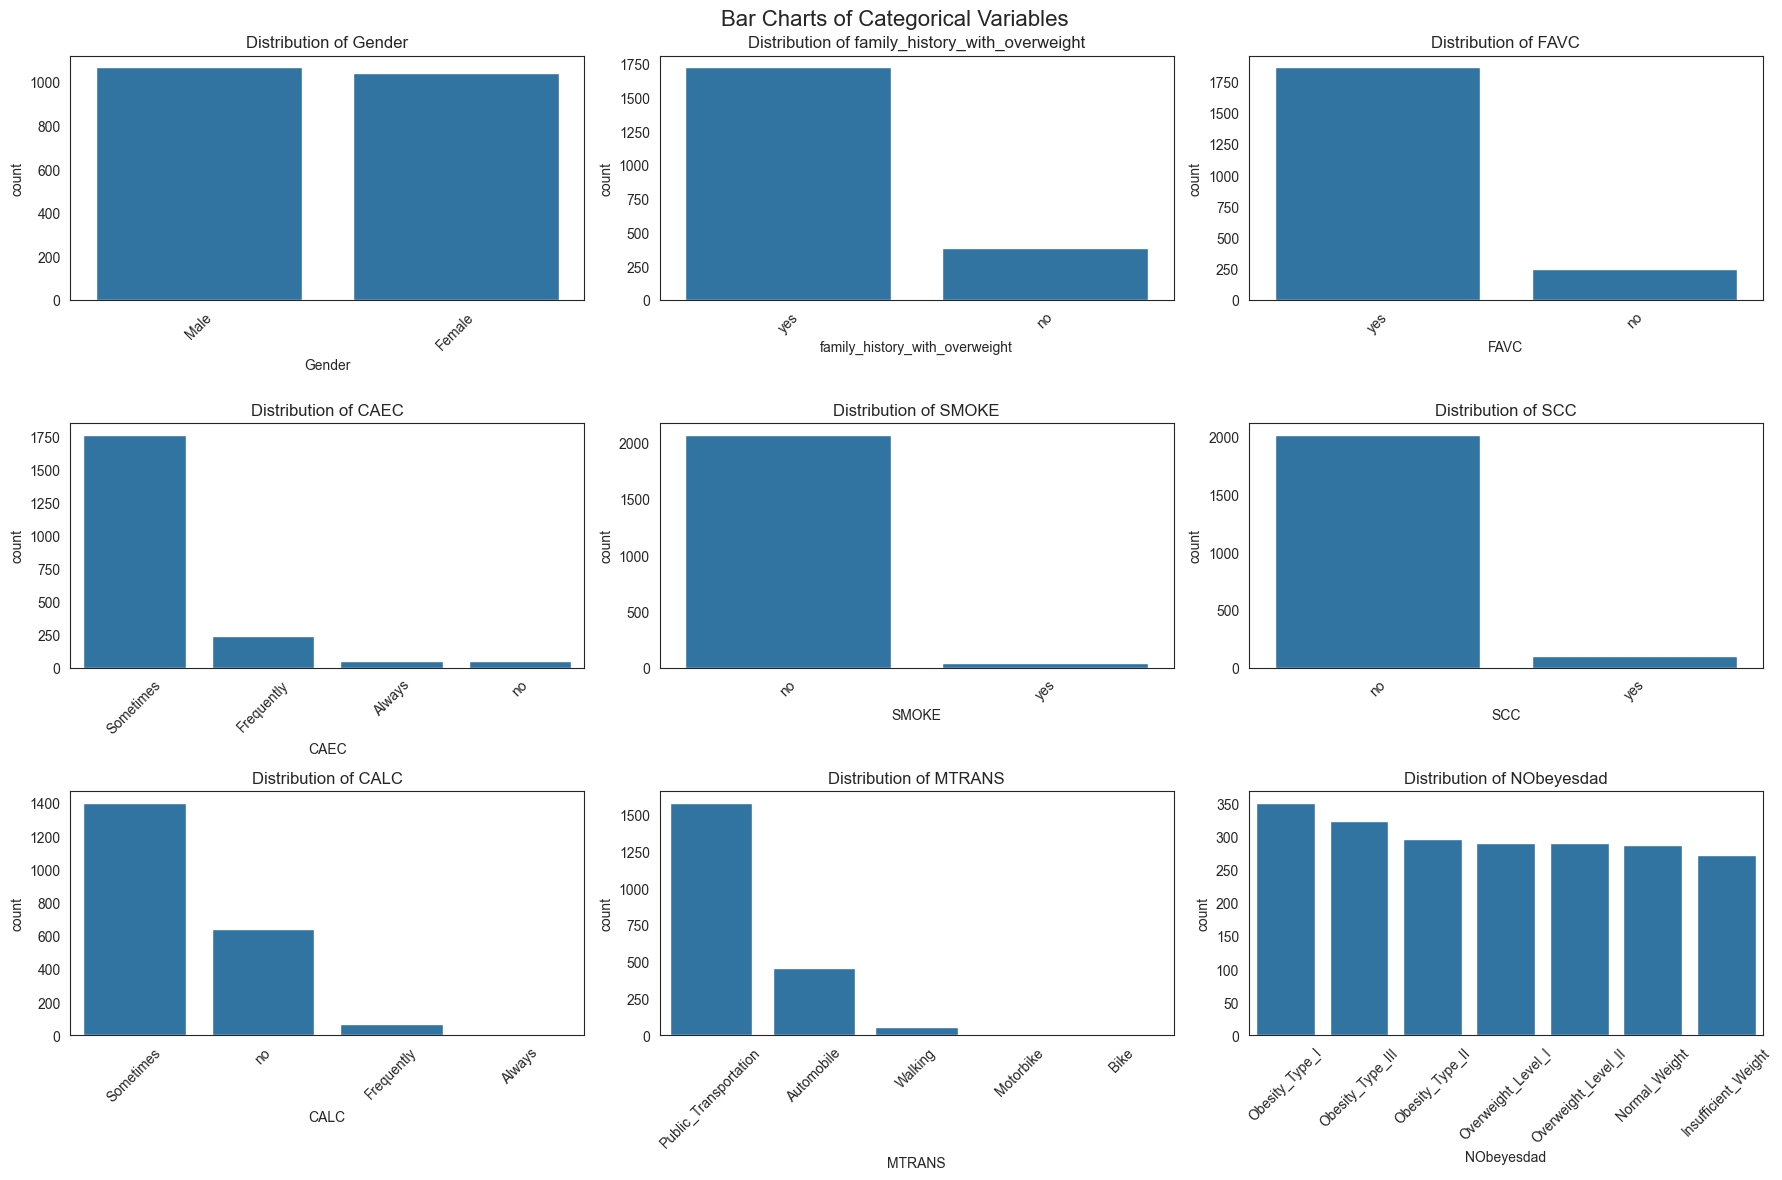

In [25]:
numerical_cols = obesity.select_dtypes(include=['float64', 'int64']).columns

sns.set_style("white")

numerical_cols = obesity.select_dtypes(include=['float64', 'int64']).columns
n = len(numerical_cols)

fig, axes = plt.subplots(nrows=(n // 3 + 1), ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data=obesity, x=col, kde=False, bins=30, ax=axes[i])
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_ylabel("Count")

for j in range(len(numerical_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Histograms of Numerical Variables", fontsize=16)
plt.tight_layout()
plt.savefig("Histograms_noWeight.png")
plt.show()

categorical_cols = obesity.select_dtypes(include='object').columns
n = len(categorical_cols)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=obesity, x=col, order=obesity[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)

for i in range(len(categorical_cols), len(axes)):
    axes[i].set_visible(False)

plt.suptitle("Bar Charts of Categorical Variables", fontsize=16)
plt.tight_layout()
plt.savefig("BarCharts_noWeight.png")
plt.show()

Step 4: Collapse Response Variable

ObeseBinary
0    1139
1     972
Name: count, dtype: int64


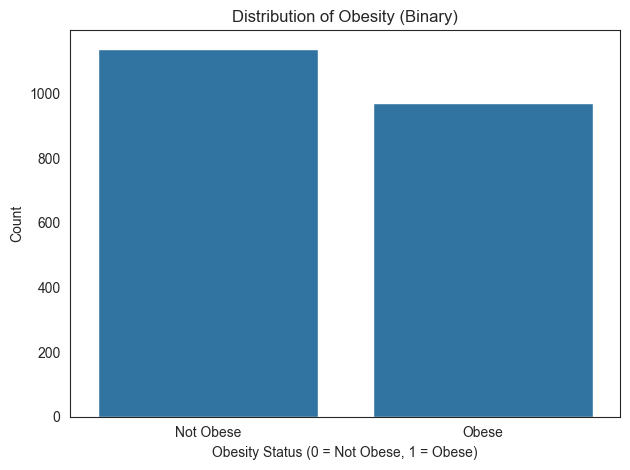

In [26]:
obese_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 0,
    'Overweight_Level_II': 0,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
}

obesity['ObeseBinary'] = obesity['NObeyesdad'].map(obese_map)

print(obesity['ObeseBinary'].value_counts())

obesity.drop(columns=['NObeyesdad'], inplace=True)

sns.countplot(data=obesity, x='ObeseBinary')
plt.title("Distribution of Obesity (Binary)")
plt.xlabel("Obesity Status (0 = Not Obese, 1 = Obese)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Obese', 'Obese'])
plt.tight_layout()
plt.savefig("ResponseDist_noWeight")
plt.show()

Step 5: Map Categorical Variables

In [27]:
binary_map = {
    'Gender': {'Male': 0, 'Female': 1},
    'family_history_with_overweight': {'no': 0, 'yes': 1},
    'FAVC': {'no': 0, 'yes': 1},
    'SMOKE': {'no': 0, 'yes': 1},
    'SCC': {'no': 0, 'yes': 1}
}

ordinal_map = {
    'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
    'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
}

obesity.replace(binary_map, inplace=True)
obesity.replace(ordinal_map, inplace=True)

mtrans_map = {
    'Public_Transportation': 0,
    'Automobile': 1,
    'Walking': 2,
    'Motorbike': 3,
    'Bike': 4
}
obesity['MTRANS'] = obesity['MTRANS'].map(mtrans_map)

C:\Users\adely\AppData\Local\Temp\ipykernel_12204\2623299550.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obesity.replace(binary_map, inplace=True)
C:\Users\adely\AppData\Local\Temp\ipykernel_12204\2623299550.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obesity.replace(ordinal_map, inplace=True)


Step 6: Calculate Correlation Matrix 

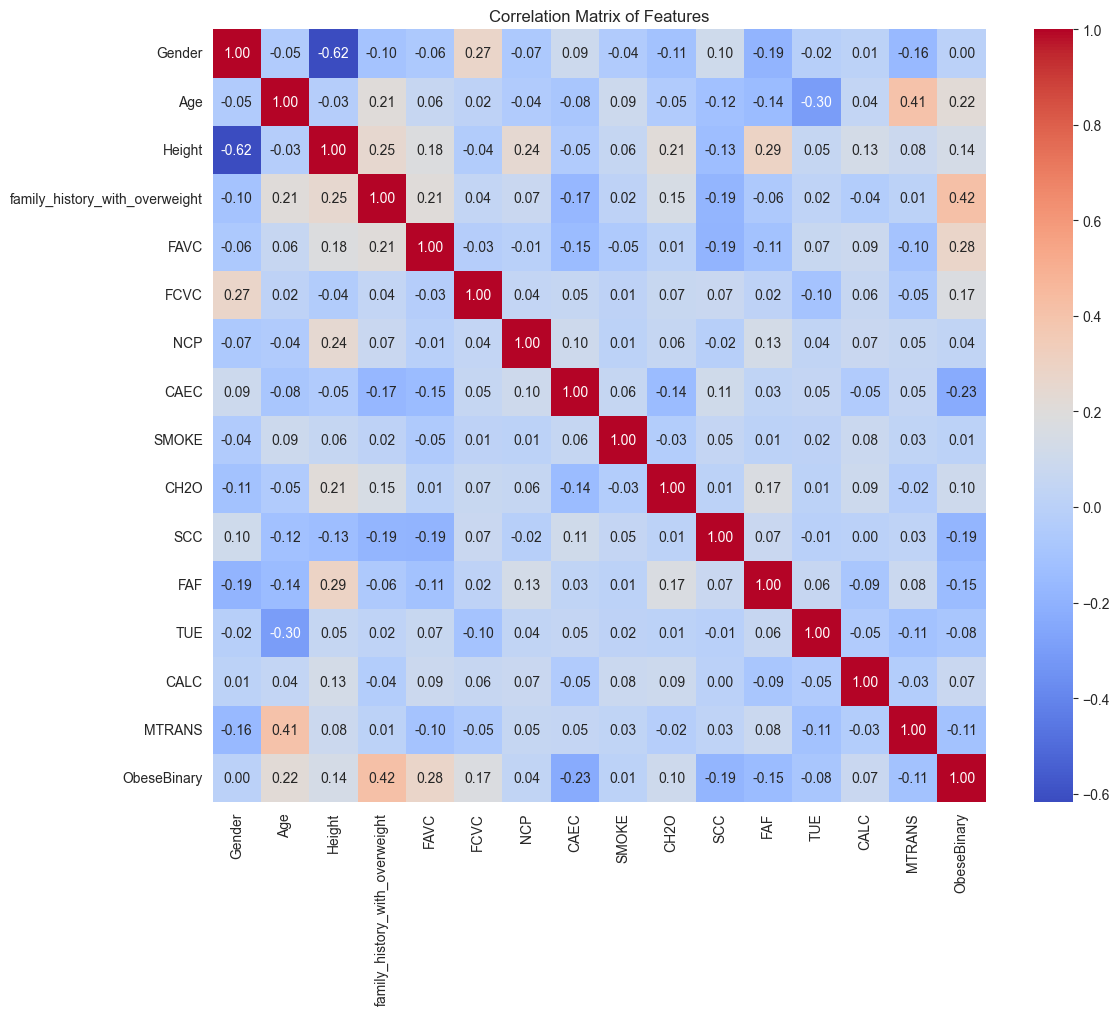

In [28]:
corr_matrix = obesity.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.savefig("CorrelationHeat_noWeight")
plt.show()

Step 7: Split Data into Training and Validation Sets, Fit Baseline Models

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def tune_knn():
    def objective(trial):
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int("n_neighbors", 3, 25)
        )
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="k-NN")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_lda():
    def objective(trial):
        model = LinearDiscriminantAnalysis()
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="LDA")
    study.optimize(objective, n_trials=1)
    return {}, study.best_value

def tune_qda():
    def objective(trial):
        model = QuadraticDiscriminantAnalysis()
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="QDA")
    study.optimize(objective, n_trials=1)
    return {}, study.best_value

def tune_logistic_regression():
    def objective(trial):
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        solver = "saga"
        C = trial.suggest_float("C", 1e-3, 10.0, log=True)

        kwargs = {
            "penalty": penalty,
            "solver": solver,
            "C": C,
            "max_iter": 5000,
            "class_weight": 'balanced',
            "random_state": seed
        }

        if penalty == "elasticnet":
            kwargs["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

        model = LogisticRegression(**kwargs)
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()

    study = optuna.create_study(direction="maximize", study_name="LogisticRegression")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_decision_tree():
    def objective(trial):
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="DecisionTree")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_random_forest():
    def objective(trial):
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 200),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="RandomForest")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_gradient_boosting():
    def objective(trial):
        model = GradientBoostingClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 200),
            learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="GradientBoosting")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_svm():
    def objective(trial):
        model = SVC(
            C=trial.suggest_float("C", 1e-3, 10.0, log=True),
            gamma=trial.suggest_float("gamma", 1e-4, 1e-1, log=True),
            kernel="rbf",
            probability=True,
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="SVM")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

print("Tuning k-NN...")
knn_params, knn_score = tune_knn()

print("Evaluating LDA...")
lda_params, lda_score = tune_lda()

print("Evaluating QDA...")
qda_params, qda_score = tune_qda()

print("Tuning Logistic Regression...")
logreg_params, logreg_score = tune_logistic_regression()

print("Tuning Decision Tree...")
tree_params, tree_score = tune_decision_tree()

print("Tuning Random Forest...")
rf_params, rf_score = tune_random_forest()

print("Tuning Gradient Boosting...")
gb_params, gb_score = tune_gradient_boosting()

print("Tuning SVM...")
svm_params, svm_score = tune_svm()

print("\n Summary:")
print("k-NN:", knn_params, f"Balanced Accuracy: {knn_score:.4f}")
print("LDA:", f"Balanced Accuracy: {lda_score:.4f}")
print("QDA:", f"Balanced Accuracy: {qda_score:.4f}")
print("Logistic Regression:", logreg_params, f"Balanced Accuracy: {logreg_score:.4f}")
print("Decision Tree:", tree_params, f"Balanced Accuracy: {tree_score:.4f}")
print("Random Forest:", rf_params, f"Balanced Accuracy: {rf_score:.4f}")
print("Gradient Boosting:", gb_params, f"Balanced Accuracy: {gb_score:.4f}")
print("SVM:", svm_params, f"Balanced Accuracy: {svm_score:.4f}")


[I 2025-04-18 20:57:32,931] A new study created in memory with name: k-NN
[I 2025-04-18 20:57:33,094] Trial 0 finished with value: 0.8445765560017279 and parameters: {'n_neighbors': 25}. Best is trial 0 with value: 0.8445765560017279.


Tuning k-NN...


[I 2025-04-18 20:57:33,229] Trial 1 finished with value: 0.9097490426020304 and parameters: {'n_neighbors': 4}. Best is trial 1 with value: 0.9097490426020304.
[I 2025-04-18 20:57:33,361] Trial 2 finished with value: 0.8844023744631888 and parameters: {'n_neighbors': 11}. Best is trial 1 with value: 0.9097490426020304.
[I 2025-04-18 20:57:33,512] Trial 3 finished with value: 0.8588780767971672 and parameters: {'n_neighbors': 21}. Best is trial 1 with value: 0.9097490426020304.
[I 2025-04-18 20:57:33,650] Trial 4 finished with value: 0.889848046365762 and parameters: {'n_neighbors': 12}. Best is trial 1 with value: 0.9097490426020304.
[I 2025-04-18 20:57:33,811] Trial 5 finished with value: 0.8842886489502038 and parameters: {'n_neighbors': 14}. Best is trial 1 with value: 0.9097490426020304.
[I 2025-04-18 20:57:33,959] Trial 6 finished with value: 0.8664483876778959 and parameters: {'n_neighbors': 17}. Best is trial 1 with value: 0.9097490426020304.
[I 2025-04-18 20:57:34,105] Trial 7 

Evaluating LDA...
Evaluating QDA...
Tuning Logistic Regression...


[I 2025-04-18 20:57:40,117] Trial 4 finished with value: 0.726885342755253 and parameters: {'penalty': 'l1', 'C': 0.015782715857282487}. Best is trial 0 with value: 0.7596629881664254.
[I 2025-04-18 20:57:40,146] Trial 5 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.002168315642143136}. Best is trial 0 with value: 0.7596629881664254.
[I 2025-04-18 20:57:40,202] Trial 6 finished with value: 0.7659122448149418 and parameters: {'penalty': 'l1', 'C': 3.3364731168292625}. Best is trial 6 with value: 0.7659122448149418.
[I 2025-04-18 20:57:40,253] Trial 7 finished with value: 0.7098378476802593 and parameters: {'penalty': 'elasticnet', 'C': 0.0021808223259749313, 'l1_ratio': 0.23359525900940814}. Best is trial 6 with value: 0.7659122448149418.
[I 2025-04-18 20:57:40,308] Trial 8 finished with value: 0.7638792390405293 and parameters: {'penalty': 'l1', 'C': 7.548768790826751}. Best is trial 6 with value: 0.7659122448149418.
[I 2025-04-18 20:57:40,360] Trial 9 finished with

Tuning Decision Tree...


[I 2025-04-18 20:57:42,881] Trial 3 finished with value: 0.8714862574407789 and parameters: {'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8764137818817883.
[I 2025-04-18 20:57:42,943] Trial 4 finished with value: 0.8782930422301126 and parameters: {'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.8782930422301126.
[I 2025-04-18 20:57:42,989] Trial 5 finished with value: 0.7709739115106646 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.8782930422301126.
[I 2025-04-18 20:57:43,053] Trial 6 finished with value: 0.8725649645612628 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.8782930422301126.
[I 2025-04-18 20:57:43,136] Trial 7 finished with value: 0.8871070503619418 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 7 w

Tuning Random Forest...


[I 2025-04-18 20:57:46,773] Trial 0 finished with value: 0.8098601336967282 and parameters: {'n_estimators': 58, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8098601336967282.
[I 2025-04-18 20:57:47,783] Trial 1 finished with value: 0.8980735138297276 and parameters: {'n_estimators': 98, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8980735138297276.
[I 2025-04-18 20:57:49,366] Trial 2 finished with value: 0.9157509060655544 and parameters: {'n_estimators': 149, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9157509060655544.
[I 2025-04-18 20:57:51,210] Trial 3 finished with value: 0.8932948146512398 and parameters: {'n_estimators': 193, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.9157509060655544.
[I 2025-04-18 20:57:52,453] Trial 4 finished with value: 0.8696654385628474 and parameters: {'

Tuning Gradient Boosting...


[I 2025-04-18 20:58:55,631] Trial 0 finished with value: 0.9334914662281134 and parameters: {'n_estimators': 108, 'learning_rate': 0.1327597508253588, 'max_depth': 5, 'subsample': 0.5564246265433472}. Best is trial 0 with value: 0.9334914662281134.
[I 2025-04-18 20:58:58,824] Trial 1 finished with value: 0.8627003174861452 and parameters: {'n_estimators': 120, 'learning_rate': 0.004164343459589767, 'max_depth': 6, 'subsample': 0.6597278119044383}. Best is trial 0 with value: 0.9334914662281134.
[I 2025-04-18 20:59:05,311] Trial 2 finished with value: 0.8766204674930217 and parameters: {'n_estimators': 156, 'learning_rate': 0.004210043542858725, 'max_depth': 7, 'subsample': 0.9539154707851667}. Best is trial 0 with value: 0.9334914662281134.
[I 2025-04-18 20:59:08,540] Trial 3 finished with value: 0.9356221101303067 and parameters: {'n_estimators': 129, 'learning_rate': 0.05387404901613465, 'max_depth': 6, 'subsample': 0.5502645728172624}. Best is trial 3 with value: 0.9356221101303067.

Tuning SVM...


[I 2025-04-18 21:04:18,534] Trial 0 finished with value: 0.7765830238860381 and parameters: {'C': 0.029405027746973462, 'gamma': 0.05726654039226641}. Best is trial 0 with value: 0.7765830238860381.
[I 2025-04-18 21:04:20,293] Trial 1 finished with value: 0.7345303761988056 and parameters: {'C': 1.3877947826948691, 'gamma': 0.0009645166636859297}. Best is trial 0 with value: 0.7765830238860381.
[I 2025-04-18 21:04:22,569] Trial 2 finished with value: 0.5 and parameters: {'C': 0.002547891181325454, 'gamma': 0.0010118900896703919}. Best is trial 0 with value: 0.7765830238860381.
[I 2025-04-18 21:04:24,829] Trial 3 finished with value: 0.5 and parameters: {'C': 0.0021300994168981452, 'gamma': 0.0002836721384715649}. Best is trial 0 with value: 0.7765830238860381.
[I 2025-04-18 21:04:26,274] Trial 4 finished with value: 0.7576155415182384 and parameters: {'C': 9.696679692606429, 'gamma': 0.0011228292846588695}. Best is trial 0 with value: 0.7765830238860381.
[I 2025-04-18 21:04:27,530] Tri


 Summary:
k-NN: {'n_neighbors': 4} Balanced Accuracy: 0.9191
LDA: Balanced Accuracy: 0.7389
QDA: Balanced Accuracy: 0.7861
Logistic Regression: {'penalty': 'l2', 'C': 5.587966017493315} Balanced Accuracy: 0.7674
Decision Tree: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5} Balanced Accuracy: 0.8934
Random Forest: {'n_estimators': 120, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1} Balanced Accuracy: 0.9358
Gradient Boosting: {'n_estimators': 200, 'learning_rate': 0.12954326313221196, 'max_depth': 7, 'subsample': 0.5391197747577066} Balanced Accuracy: 0.9514
SVM: {'C': 3.314841521687846, 'gamma': 0.09922770635327678} Balanced Accuracy: 0.9175


Step 8: Tune Hyperparameters via Optuna with 5 Fold Cross Validation

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def tune_knn():
    def objective(trial):
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int("n_neighbors", 3, 25)
        )
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="k-NN")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_lda():
    def objective(trial):
        model = LinearDiscriminantAnalysis()
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="LDA")
    study.optimize(objective, n_trials=1)
    return {}, study.best_value

def tune_qda():
    def objective(trial):
        model = QuadraticDiscriminantAnalysis()
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="QDA")
    study.optimize(objective, n_trials=1)
    return {}, study.best_value

def tune_logistic_regression():
    def objective(trial):
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        solver = "saga"
        C = trial.suggest_float("C", 1e-3, 10.0, log=True)

        kwargs = {
            "penalty": penalty,
            "solver": solver,
            "C": C,
            "max_iter": 5000,
            "class_weight": 'balanced',
            "random_state": seed
        }

        if penalty == "elasticnet":
            kwargs["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

        model = LogisticRegression(**kwargs)
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()

    study = optuna.create_study(direction="maximize", study_name="LogisticRegression")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_decision_tree():
    def objective(trial):
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="DecisionTree")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_random_forest():
    def objective(trial):
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 200),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="RandomForest")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_gradient_boosting():
    def objective(trial):
        model = GradientBoostingClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 200),
            learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="GradientBoosting")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_svm():
    def objective(trial):
        model = SVC(
            C=trial.suggest_float("C", 1e-3, 10.0, log=True),
            gamma=trial.suggest_float("gamma", 1e-4, 1e-1, log=True),
            kernel="rbf",
            probability=True,
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="SVM")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

print("Tuning k-NN...")
knn_params, knn_score = tune_knn()

print("Evaluating LDA...")
lda_params, lda_score = tune_lda()

print("Evaluating QDA...")
qda_params, qda_score = tune_qda()

print("Tuning Logistic Regression...")
logreg_params, logreg_score = tune_logistic_regression()

print("Tuning Decision Tree...")
tree_params, tree_score = tune_decision_tree()

print("Tuning Random Forest...")
rf_params, rf_score = tune_random_forest()

print("Tuning Gradient Boosting...")
gb_params, gb_score = tune_gradient_boosting()

print("Tuning SVM...")
svm_params, svm_score = tune_svm()

print("\n Summary:")
print("k-NN:", knn_params, f"Balanced Accuracy: {knn_score:.4f}")
print("LDA:", f"Balanced Accuracy: {lda_score:.4f}")
print("QDA:", f"Balanced Accuracy: {qda_score:.4f}")
print("Logistic Regression:", logreg_params, f"Balanced Accuracy: {logreg_score:.4f}")
print("Decision Tree:", tree_params, f"Balanced Accuracy: {tree_score:.4f}")
print("Random Forest:", rf_params, f"Balanced Accuracy: {rf_score:.4f}")
print("Gradient Boosting:", gb_params, f"Balanced Accuracy: {gb_score:.4f}")
print("SVM:", svm_params, f"Balanced Accuracy: {svm_score:.4f}")


[I 2025-04-18 21:10:19,707] A new study created in memory with name: k-NN
[I 2025-04-18 21:10:19,848] Trial 0 finished with value: 0.9117719659152763 and parameters: {'n_neighbors': 4}. Best is trial 0 with value: 0.9117719659152763.


Tuning k-NN...


[I 2025-04-18 21:10:20,010] Trial 1 finished with value: 0.8624955883179046 and parameters: {'n_neighbors': 20}. Best is trial 0 with value: 0.9117719659152763.
[I 2025-04-18 21:10:20,150] Trial 2 finished with value: 0.8495736988201292 and parameters: {'n_neighbors': 23}. Best is trial 0 with value: 0.9117719659152763.
[I 2025-04-18 21:10:20,275] Trial 3 finished with value: 0.9002597904475218 and parameters: {'n_neighbors': 8}. Best is trial 0 with value: 0.9117719659152763.
[I 2025-04-18 21:10:20,425] Trial 4 finished with value: 0.852549990992614 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 0.9117719659152763.
[I 2025-04-18 21:10:20,569] Trial 5 finished with value: 0.8829319041614123 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.9117719659152763.
[I 2025-04-18 21:10:20,709] Trial 6 finished with value: 0.8744637699687938 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.9117719659152763.
[I 2025-04-18 21:10:20,855] Trial 7 

Evaluating LDA...
Evaluating QDA...
Tuning Logistic Regression...


[I 2025-04-18 21:10:26,682] Trial 4 finished with value: 0.7626268152788512 and parameters: {'penalty': 'l2', 'C': 0.11677508284247202}. Best is trial 0 with value: 0.7637058323308985.
[I 2025-04-18 21:10:26,723] Trial 5 finished with value: 0.7584450927179642 and parameters: {'penalty': 'l2', 'C': 0.00866739036768729}. Best is trial 0 with value: 0.7637058323308985.
[I 2025-04-18 21:10:26,769] Trial 6 finished with value: 0.7371570752533205 and parameters: {'penalty': 'elasticnet', 'C': 0.007241956097820915, 'l1_ratio': 0.3128545187735068}. Best is trial 0 with value: 0.7637058323308985.
[I 2025-04-18 21:10:26,820] Trial 7 finished with value: 0.761314342276796 and parameters: {'penalty': 'elasticnet', 'C': 7.848659649809089, 'l1_ratio': 0.8783162447159346}. Best is trial 0 with value: 0.7637058323308985.
[I 2025-04-18 21:10:26,843] Trial 8 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.0014864177158141925}. Best is trial 0 with value: 0.7637058323308985.
[I 2025-04

Tuning Decision Tree...


[I 2025-04-18 21:10:29,098] Trial 3 finished with value: 0.8877300031186863 and parameters: {'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8877300031186863.
[I 2025-04-18 21:10:29,176] Trial 4 finished with value: 0.8794946469007812 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8877300031186863.
[I 2025-04-18 21:10:29,244] Trial 5 finished with value: 0.8792301493676428 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8877300031186863.
[I 2025-04-18 21:10:29,305] Trial 6 finished with value: 0.8652877036589357 and parameters: {'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8877300031186863.
[I 2025-04-18 21:10:29,347] Trial 7 finished with value: 0.7430356246961217 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 3 w

Tuning Random Forest...


[I 2025-04-18 21:10:33,764] Trial 0 finished with value: 0.904626842397863 and parameters: {'n_estimators': 120, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.904626842397863.
[I 2025-04-18 21:10:35,033] Trial 1 finished with value: 0.8932752695920332 and parameters: {'n_estimators': 123, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.904626842397863.
[I 2025-04-18 21:10:35,587] Trial 2 finished with value: 0.8520507590417692 and parameters: {'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.904626842397863.
[I 2025-04-18 21:10:36,558] Trial 3 finished with value: 0.8839586880596929 and parameters: {'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.904626842397863.
[I 2025-04-18 21:10:38,413] Trial 4 finished with value: 0.8956544398664971 and parameters: {'n_es

Tuning Gradient Boosting...


[I 2025-04-18 21:11:50,731] Trial 0 finished with value: 0.8715655708648834 and parameters: {'n_estimators': 50, 'learning_rate': 0.05058935341579714, 'max_depth': 4, 'subsample': 0.5736218345459883}. Best is trial 0 with value: 0.8715655708648834.
[I 2025-04-18 21:11:51,902] Trial 1 finished with value: 0.869463082308138 and parameters: {'n_estimators': 87, 'learning_rate': 0.04129398982117118, 'max_depth': 3, 'subsample': 0.6029938926959957}. Best is trial 0 with value: 0.8715655708648834.
[I 2025-04-18 21:11:56,363] Trial 2 finished with value: 0.8401720120175964 and parameters: {'n_estimators': 145, 'learning_rate': 0.0016196951321287073, 'max_depth': 6, 'subsample': 0.7530424077439439}. Best is trial 0 with value: 0.8715655708648834.
[I 2025-04-18 21:12:05,138] Trial 3 finished with value: 0.9437591502451366 and parameters: {'n_estimators': 124, 'learning_rate': 0.14466890684083075, 'max_depth': 9, 'subsample': 0.9198787241072465}. Best is trial 3 with value: 0.9437591502451366.
[

Tuning SVM...


[I 2025-04-18 21:17:46,501] Trial 0 finished with value: 0.5 and parameters: {'C': 0.0031575506123222453, 'gamma': 0.0005019244790040879}. Best is trial 0 with value: 0.5.
[I 2025-04-18 21:17:48,874] Trial 1 finished with value: 0.6776931503187452 and parameters: {'C': 0.5758683130039336, 'gamma': 0.0003962725167896601}. Best is trial 1 with value: 0.6776931503187452.
[I 2025-04-18 21:17:50,360] Trial 2 finished with value: 0.8368718413615295 and parameters: {'C': 0.2712033097725552, 'gamma': 0.06684621756689427}. Best is trial 2 with value: 0.8368718413615295.
[I 2025-04-18 21:17:52,723] Trial 3 finished with value: 0.5 and parameters: {'C': 0.0015179696024788293, 'gamma': 0.0006932559721379303}. Best is trial 2 with value: 0.8368718413615295.
[I 2025-04-18 21:17:54,434] Trial 4 finished with value: 0.7505747390279385 and parameters: {'C': 0.40839313752520096, 'gamma': 0.005972184975242867}. Best is trial 2 with value: 0.8368718413615295.
[I 2025-04-18 21:17:55,980] Trial 5 finished w


 Summary:
k-NN: {'n_neighbors': 4} Balanced Accuracy: 0.9169
LDA: Balanced Accuracy: 0.7433
QDA: Balanced Accuracy: 0.7880
Logistic Regression: {'penalty': 'elasticnet', 'C': 0.1250217258049949, 'l1_ratio': 0.33006428268108545} Balanced Accuracy: 0.7657
Decision Tree: {'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 8} Balanced Accuracy: 0.8877
Random Forest: {'n_estimators': 159, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1} Balanced Accuracy: 0.9432
Gradient Boosting: {'n_estimators': 125, 'learning_rate': 0.11981951922694908, 'max_depth': 10, 'subsample': 0.7758157829841021} Balanced Accuracy: 0.9513
SVM: {'C': 3.3827912569627663, 'gamma': 0.09631374273916378} Balanced Accuracy: 0.9172


Step 9: Evaluate Models on Test Data

In [35]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"{model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 40)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Not Obese (0)", "Obese (1)"],
                yticklabels=["Not Obese (0)", "Obese (1)"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_confusion_withoutWeight.png", dpi=300)
    plt.close()

knn_model = KNeighborsClassifier(**knn_params)
knn_model.fit(X_train_scaled, y_train)
evaluate_model(knn_model, X_test_scaled, y_test, "k-NN")

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_scaled, y_train)
evaluate_model(lda_model, X_test_scaled, y_test, "LDA")

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_scaled, y_train)
evaluate_model(qda_model, X_test_scaled, y_test, "QDA")

log_model = LogisticRegression(**logreg_params, max_iter=5000, solver='saga', class_weight='balanced', random_state=seed)
log_model.fit(X_train_scaled, y_train)
evaluate_model(log_model, X_test_scaled, y_test, "Logistic Regression")

tree_model = DecisionTreeClassifier(**tree_params, class_weight='balanced', random_state=seed)
tree_model.fit(X_train, y_train)
evaluate_model(tree_model, X_test, y_test, "Decision Tree")

rf_model = RandomForestClassifier(**rf_params, class_weight='balanced', random_state=seed)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

gb_model = GradientBoostingClassifier(**gb_params, random_state=seed)
gb_model.fit(X_train, y_train)
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

svm_model = SVC(**svm_params, probability=True, class_weight='balanced', random_state=seed)
svm_model.fit(X_train_scaled, y_train)
evaluate_model(svm_model, X_test_scaled, y_test, "SVM")


k-NN:
Accuracy: 0.9219858156028369
Balanced Accuracy: 0.9209514170040486
Precision: 0.921875
Recall: 0.9076923076923077
F1 Score: 0.9147286821705426
ROC AUC: 0.9675101214574899
Confusion Matrix:
 [[213  15]
 [ 18 177]]
----------------------------------------
LDA:
Accuracy: 0.7588652482269503
Balanced Accuracy: 0.7629554655870445
Precision: 0.7066666666666667
Recall: 0.8153846153846154
F1 Score: 0.7571428571428571
ROC AUC: 0.8523166891587945
Confusion Matrix:
 [[162  66]
 [ 36 159]]
----------------------------------------
QDA:
Accuracy: 0.8037825059101655
Balanced Accuracy: 0.8142712550607287
Precision: 0.7170542635658915
Recall: 0.9487179487179487
F1 Score: 0.8167770419426048
ROC AUC: 0.9353351327035537
Confusion Matrix:
 [[155  73]
 [ 10 185]]
----------------------------------------
Logistic Regression:
Accuracy: 0.7848699763593381
Balanced Accuracy: 0.7911605937921727
Precision: 0.7203389830508474
Recall: 0.8717948717948718
F1 Score: 0.7888631090487239
ROC AUC: 0.8606837606837607


Step 10: Permutation Feature Importance

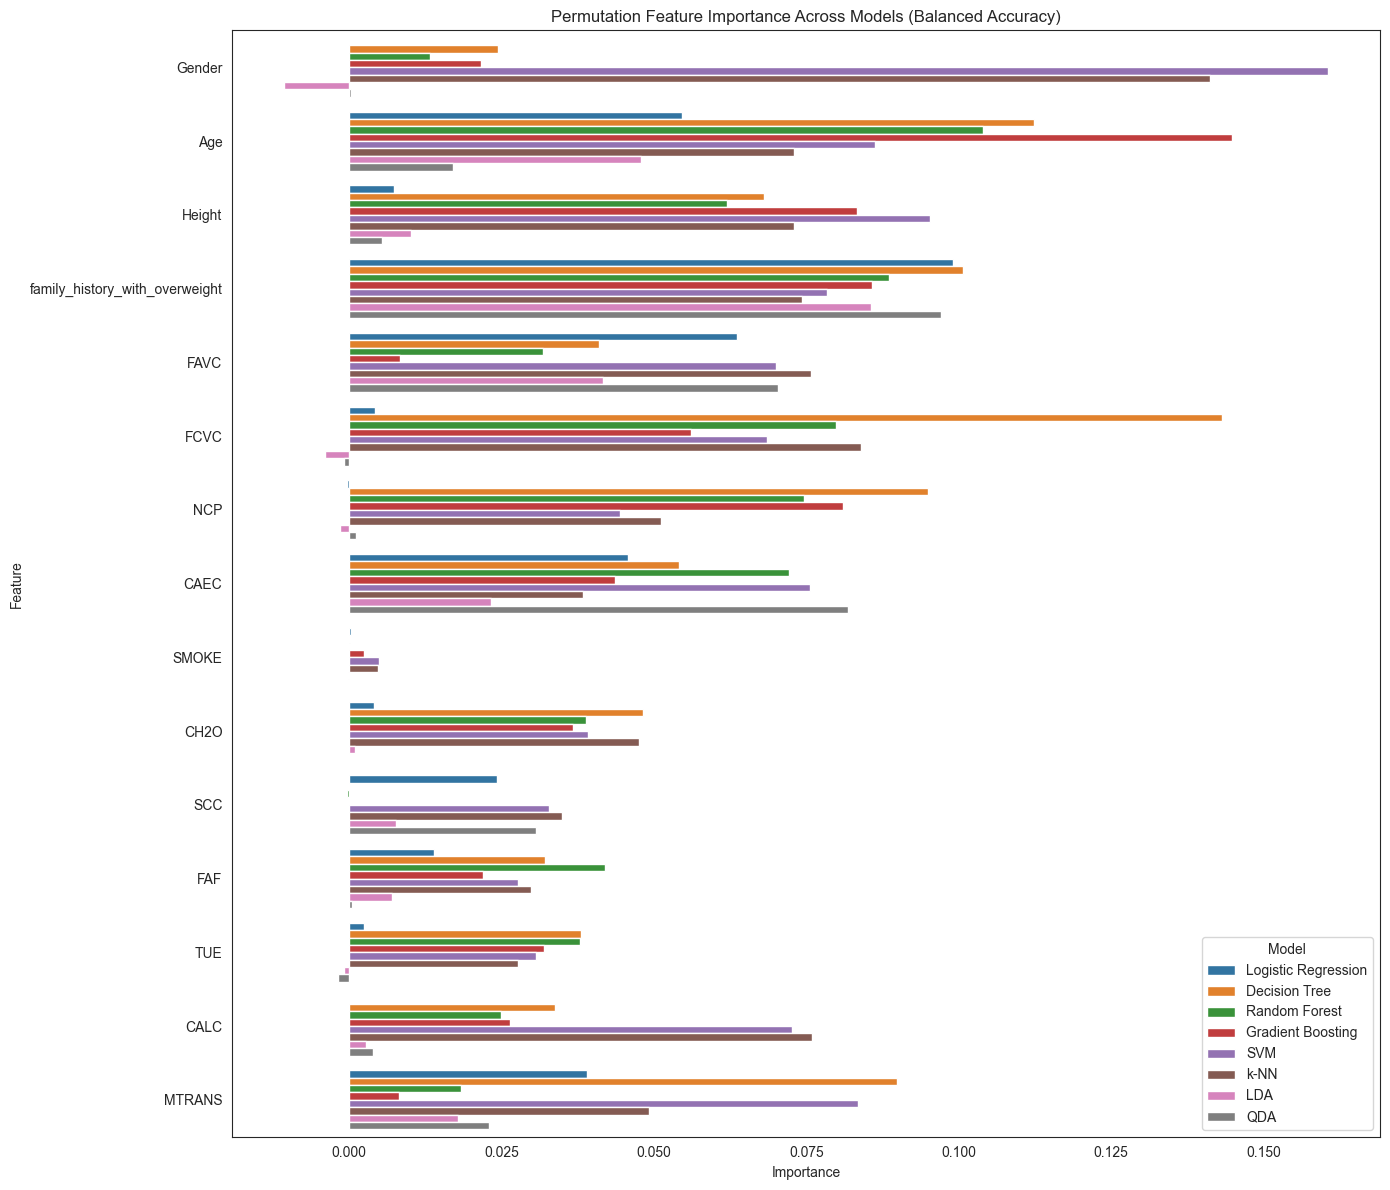

In [36]:
feature_names = X_test.columns

def get_permutation_importance(model, X, y, feature_names, model_name):
    result = permutation_importance(
        model, X, y,
        n_repeats=30,
        random_state=seed,
        scoring='balanced_accuracy'
    )
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean,
        'Model': model_name
    })

knn_pi  = get_permutation_importance(knn_model, X_test_scaled, y_test, feature_names, 'k-NN')
lda_pi  = get_permutation_importance(lda_model, X_test_scaled, y_test, feature_names, 'LDA')
qda_pi  = get_permutation_importance(qda_model, X_test_scaled, y_test, feature_names, 'QDA')
log_pi = get_permutation_importance(log_model, X_test_scaled, y_test, feature_names, 'Logistic Regression')
tree_pi = get_permutation_importance(tree_model, X_test, y_test, feature_names, 'Decision Tree')
rf_pi   = get_permutation_importance(rf_model, X_test, y_test, feature_names, 'Random Forest')
gb_pi   = get_permutation_importance(gb_model, X_test, y_test, feature_names, 'Gradient Boosting')
svm_pi  = get_permutation_importance(svm_model, X_test_scaled, y_test, feature_names, 'SVM')

all_importance = pd.concat([
    log_pi, tree_pi, rf_pi, gb_pi, svm_pi,
    knn_pi, lda_pi, qda_pi
])

plt.figure(figsize=(14, 12))
sns.barplot(data=all_importance, x='Importance', y='Feature', hue='Model')
plt.title("Permutation Feature Importance Across Models (Balanced Accuracy)")
plt.tight_layout()
plt.savefig("Feature_Importance_noWeight")
plt.show()
